<a href="https://colab.research.google.com/github/iych0/spotify-analysis/blob/main/spotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Подготовка к работе

### Импорты библиотек

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance

In [ ]:
df = pd.read_csv('/content/dataset.csv')

## Первичный анализ датасета

In [ ]:
df.head(4)

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.358,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.101,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.117,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.132,0.143,181.740,3,acoustic


Описание полей:


*   track_id: Уникальный идентификатор трека
*   artists: Автор трека
*   album_name: Название альбома (трека, если это сингл)
*   track_name: Название трека
*   popuarity: Численная мера популярности
*   duration_ms: Длительность трека в милисекундах
*   explicit: Флаг, указывающий на возрастные ограничения
*   danceability: Условный показатель, отражающий степень "танцевальности" трека
*   energy: Условный показатель, отражающий степень энергичности трека
*   key: Тональность
*   loudness: Громкость трек в децибелах
*   mode: Модальность трека (0 — минор, 1 — мажор)
*   speechiness: Флаг, указывающий на наличие слов в треке
*   acousticness: Условный показатель, отражающий степень акустичности трека
*   instrumentalness: Условный показатель, отражающий степень инструментальности трека
*   liveness: Условный показатель, отражающий степень живости (?) трека
*   valence: Условный показатель, отражающий эмоциональную позитивность трека
*   tempo: Темп трека
*   time_signature: Размерность трека
*   track_genre: Жанр трека

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

Немного подкорректируем таблицу: удалим нулевые значения и лишнюю колонку


In [ ]:
df=df.dropna()
df = df.drop(columns=['Unnamed: 0'])

## Предварительная аналитика: поиск зависимостей, построение графиков

### 1. Общая статистика популярности треков
Сперва оценим распределение треков по параметру популярности

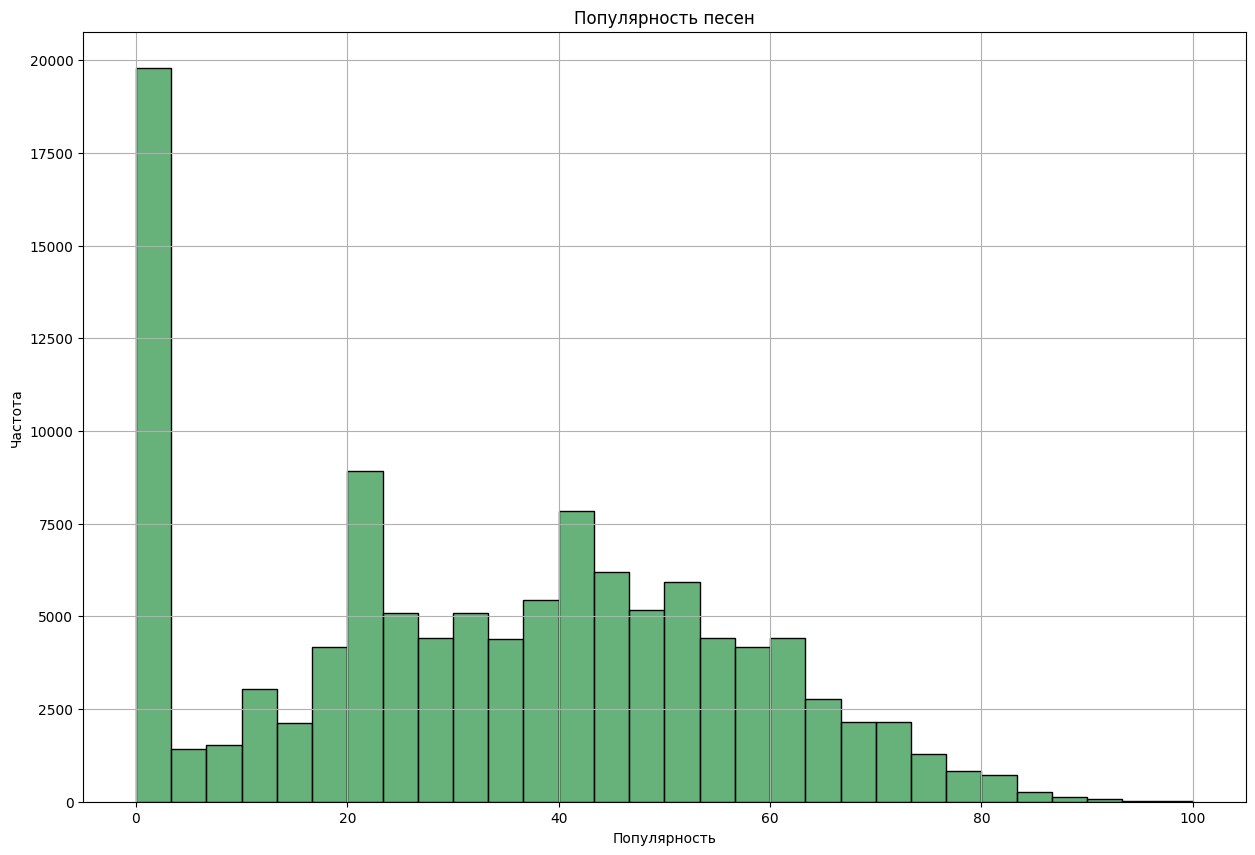

Средняя популярность: 33.23882665637418


In [ ]:
plt.figure(figsize=(15, 10))
sns.histplot(df['popularity'], bins=30,color='#34994f')
plt.title('Популярность песен')
plt.xlabel('Популярность')
plt.ylabel('Частота')
plt.grid(True)
plt.show()
print(f'Средняя популярность: {df["popularity"].mean()}')

График предсказуемо имеет вид убывающей "лестницы" в диапазоне значений популярности от 40 до 100. В диапазоне от 0 до 40 наблюдаются сильные скачки в области околонулевой популярности и популярности в 20-22. Резонно предположить, что огромное количество песен было написано непопулярными исполнителями.

### 2. Зависимость популярности от жанра

Самая очевидная зависимость - график распределения треков по жанру




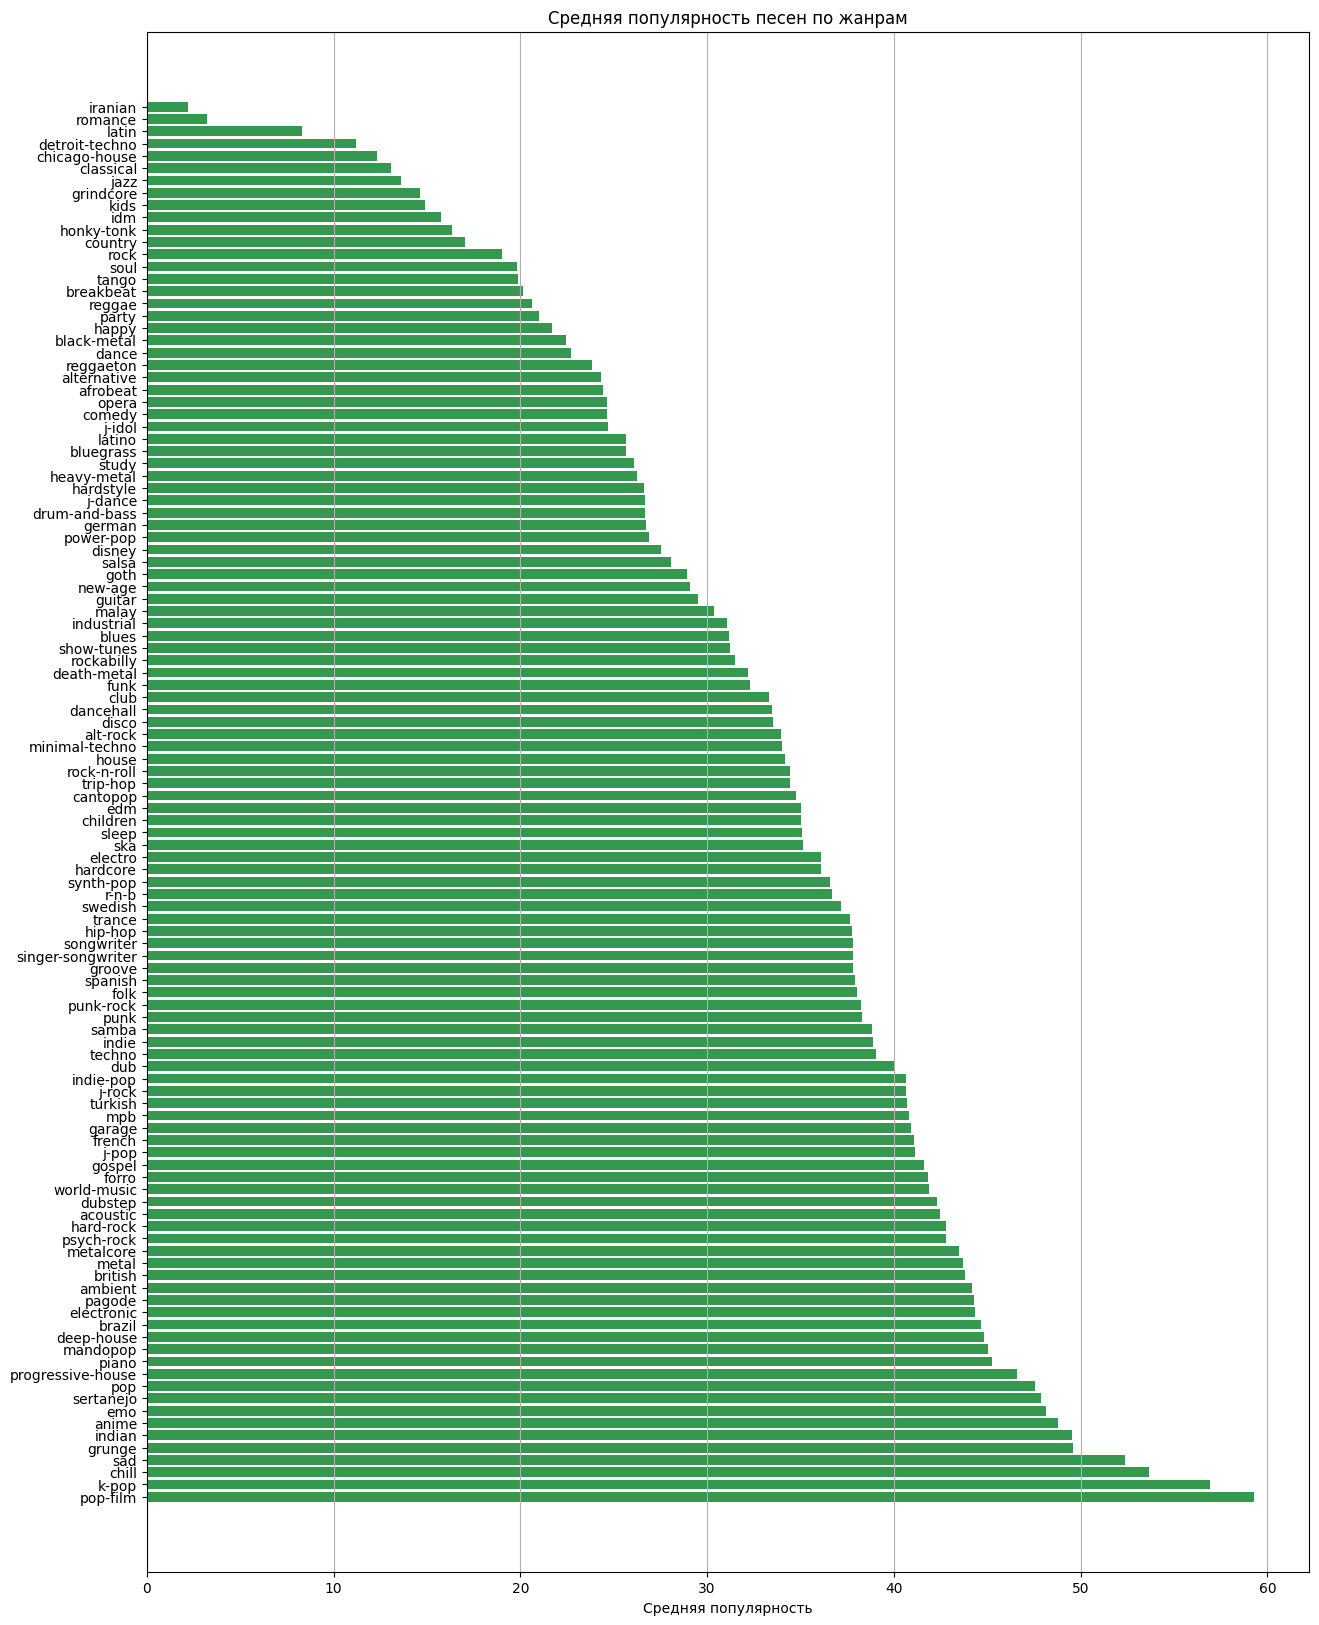

In [ ]:
average_popularity = df.groupby('track_genre')['popularity'].mean().reset_index()
average_popularity.columns = ['Жанр', 'Средняя популярность']
average_popularity = average_popularity.sort_values(by='Средняя популярность', ascending=False)
plt.figure(figsize=(15, 20))
plt.barh(average_popularity['Жанр'], average_popularity['Средняя популярность'],color='#34994f')
plt.xlabel('Средняя популярность')
plt.title('Средняя популярность песен по жанрам')
plt.grid(axis='x')
plt.show()

По вполне понятным график распределения показывает неравномерное распределение популярности.

### 3. Зависимость популярности от длительности
Примечание: построить график с длительностью, выраженной в милисекундах, не поучится. Представим длительность в минутах.

In [ ]:
df['duration_minutes'] = df['duration_ms'] / 1000 / 60

Избавимся от шумов - редких критических значений, мешающих визуализации статистики.

(Столбчатый график упорно отказывался строиться - его код останется ниже, но для визуализации будем использовать диаграмму рассеяния)

In [ ]:
# # Нерабочий график
# plt.figure(figsize=(10, 6))
# plt.barh(df['duration_minutes'], df['popularity'], color='#34994f')
# plt.xlabel('Средняя популярность')
# plt.title('Средняя популярность песен по жанрам')
# plt.grid(axis='x')
# plt.show()
# # Код выполнялся довольно долго, потому было принято решение прервать его выполнение

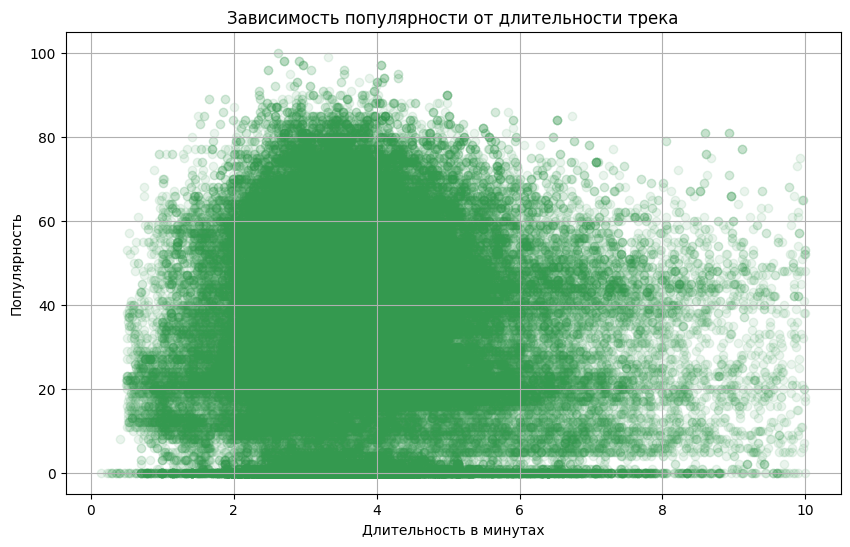

In [ ]:
df_filtered = df[df['duration_minutes'] <= 10]

plt.figure(figsize=(10, 6))
plt.scatter(data=df_filtered, x='duration_minutes', y='popularity', alpha=0.1, color='#34994f')
plt.title("Зависимость популярности от длительности трека")
plt.xlabel("Длительность в минутах")
plt.ylabel("Популярность")
plt.grid(True)
plt.show()

Наиболее популярны песни с длительностью в диапазоне от 2 до 6 минут.

### 4. Зависимость популярности от наличия слов в треке

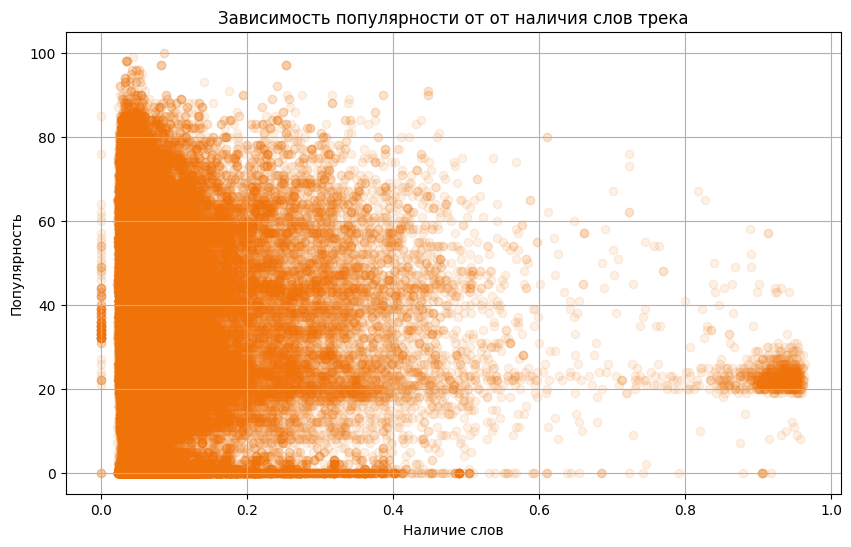

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df['speechiness'], df['popularity'], alpha=0.1, color='#ef7309')
plt.title("Зависимость популярности от от наличия слов трека")
plt.xlabel("Наличие слов")
plt.ylabel("Популярность")
plt.grid(True)
plt.show()

Интересно, что высокую популярность имеют треки с низким коэффициентом speechiness (в диапазоне 0.02 - 0.1). Как показывает график, такие треки не только популярны, но и встречаются чаще остальных.

### 5. Зависимость популярности от условных параметров: "танцевальности", энергичности, инструментальности

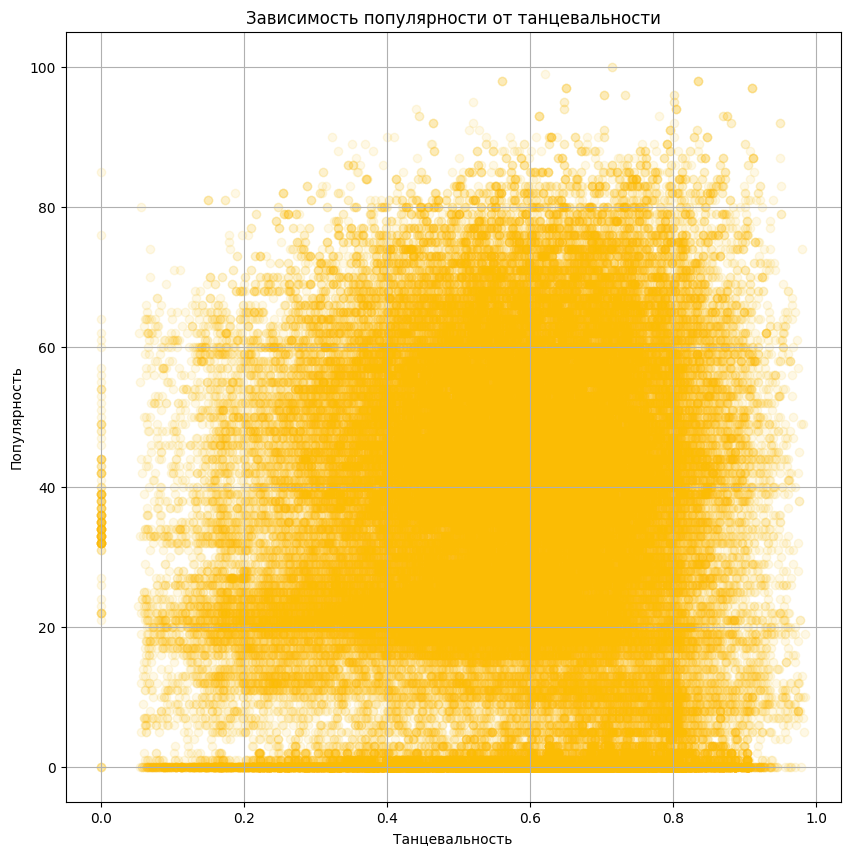

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(data=df, x='danceability', y='popularity', alpha=0.1, color='#fbbc04')
plt.title("Зависимость популярности от танцевальности")
plt.xlabel("Танцевальность")
plt.ylabel("Популярность")
plt.grid(True)
plt.show()

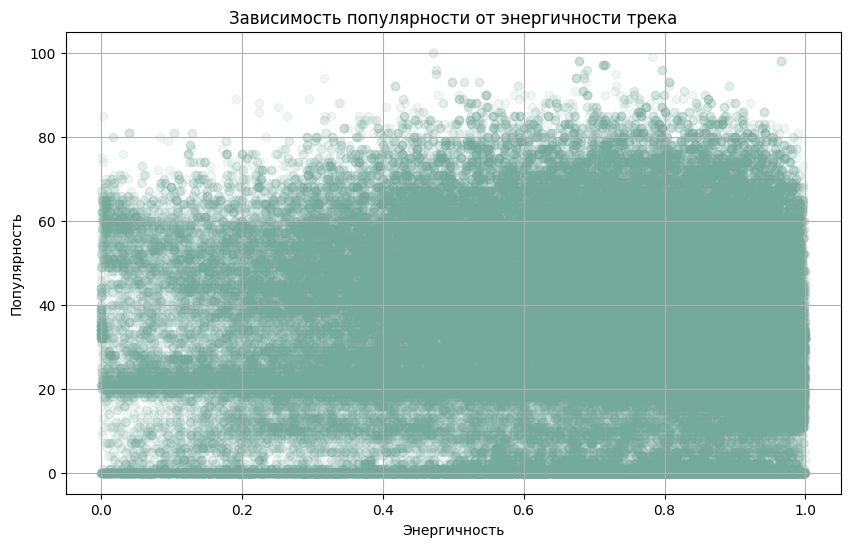

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df['energy'], df['popularity'], alpha=0.1, color='#74aa9a')
plt.title("Зависимость популярности от энергичности трека")
plt.xlabel("Энергичность")
plt.ylabel("Популярность")
plt.grid(True)
plt.show()

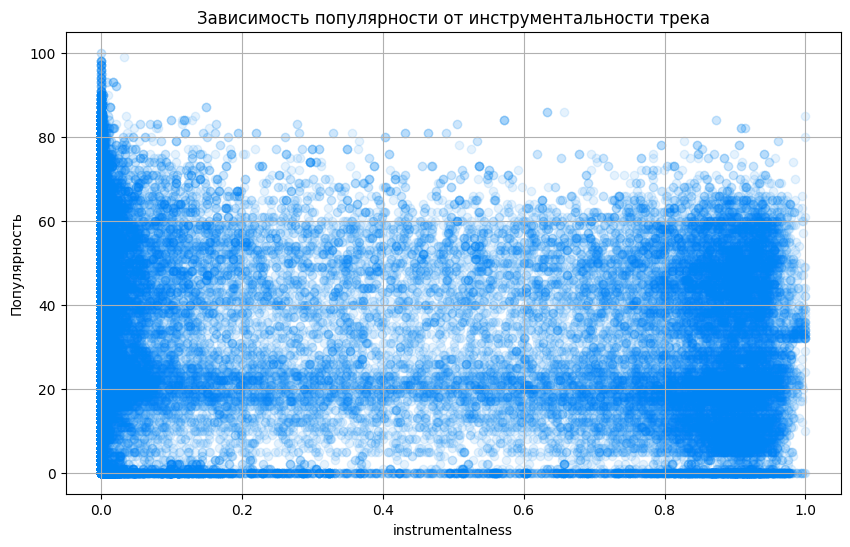

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df['instrumentalness'], df['popularity'], alpha=0.1, color='#0084f4')
plt.title("Зависимость популярности от инструментальности трека")
plt.xlabel("instrumentalness")
plt.ylabel("Популярность")
plt.grid(True)
plt.show()

Графики выглядят *размытыми* - по ним сложно строить предположения, они не демонстрируют очевидных закономерностей.

### 6. Зависимость популярности от предположительно малозначимых параметров: размерности, возрастных ограничений, является ли запись студийной

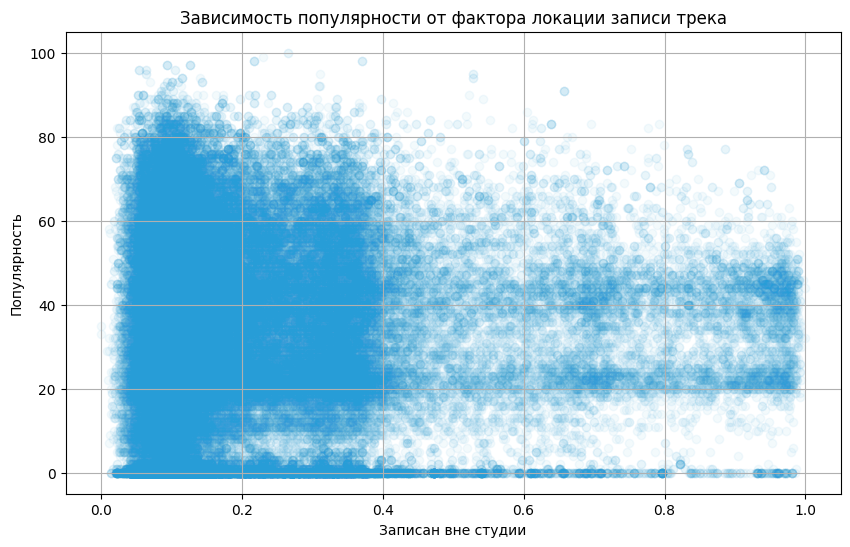

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df['liveness'], df['popularity'], alpha=0.05, color='#279dd7')
plt.title("Зависимость популярности от фактора локации записи трека")
plt.xlabel("Записан вне студии")
plt.ylabel("Популярность")
plt.grid(True)
plt.show()

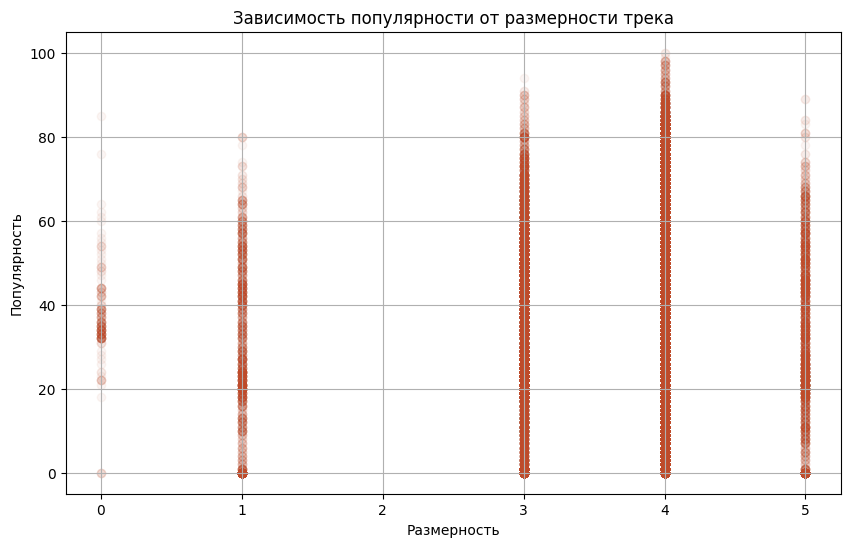

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df['time_signature'], df['popularity'], alpha=0.05, color='#be4b2a')
plt.title("Зависимость популярности от размерности трека")
plt.xlabel("Размерность")
plt.ylabel("Популярность")
plt.grid(True)
plt.show()

Как показывают графики, хитам чаще становятся неинструментальные треки, несмотря на то, что инструментальные в свою очередь являются самыми распространыенными.

Большее количество треков было записано в студии. Вместе с тем это большинство оказалось среди лидеров по популярности.

Самые распространенные и по совместительству популярные треки имеют размерность 4 и 3. (Положим, что нулевая колонка соответствует трекам с переменной размерностью)

## Построение таблицы корреляции

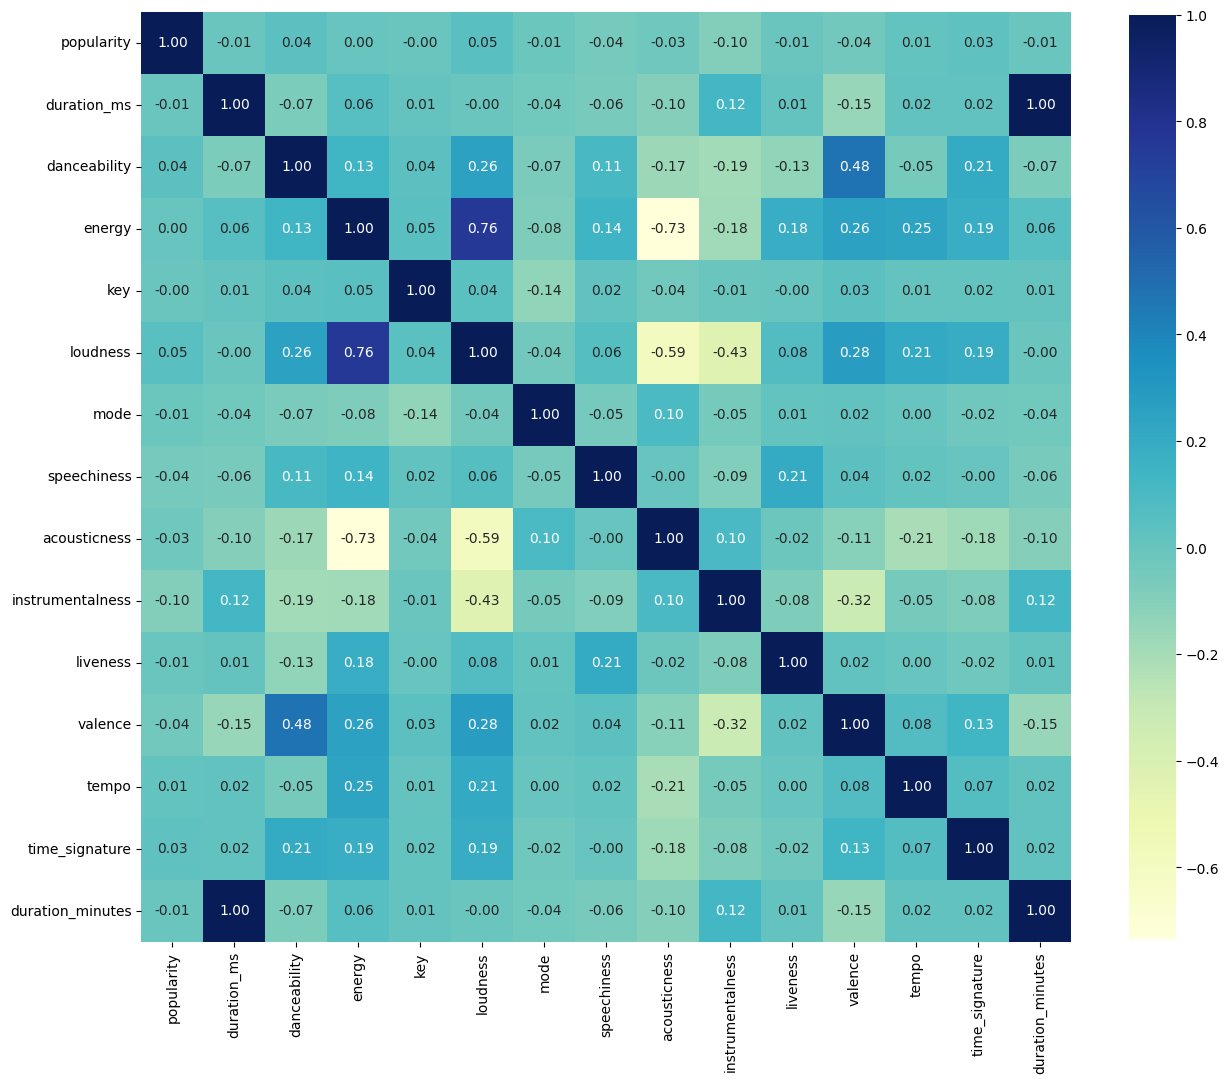

In [ ]:
numerical_features = df.select_dtypes(include=['number']).columns.tolist()
correlation_matrix = df[numerical_features].corr()
plt.figure(figsize=(15,15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='YlGnBu', square=True, cbar_kws={"shrink": .8})
plt.show()

** Наивысшая корелляция с популярностью: инструментальность**

Самые взаимозависимые признаки:

*   danceability: loudness (0.26), valence (0.48), time_signature (0.21)
*   energy: acousticness (-0.73),  loudness (0.76), valence (0.26), tempo (0.25)
*   loudness: acousticness (-0.59), instrumentalness (-0.43), valence (0.28), tempo (0.21)
*   speechness: liveness (0.21)
*   acousticness: tempo (-0.21)
*   instrumentalness: valence (-0.32)

## Feature Engineering

Скомбинируем коррелирующие признаки и получим новые. Составим выборку с показателями корреляции выше 0.3. Из малых значений будем извлекать корни для стабилизации

In [ ]:
# Позитивная танцевальная музыка
df['danceability_and_valence'] = df['danceability'] ** 0.5 * df['valence'] ** 0.5
df['danceability_and_valence']

,danceability_and_valence
0,0.695227
1,0.334873
2,0.229260
3,0.195033
4,0.321257
...,...
113995,0.076360
113996,0.078038
113997,0.683628
113998,0.492373


In [ ]:
# Энергичная акустическая музыка
df['energy_and_acousticness'] = df['energy'] ** 0.5 * df['acousticness'] ** 0.5
df['energy_and_acousticness']

,energy_and_acousticness
0,0.121837
1,0.391643
2,0.274572
3,0.232246
4,0.455815
...,...
113995,0.387814
113996,0.341025
113997,0.534081
113998,0.439074


In [ ]:
# Энергичная громкая музыка
df['energy_and_loudness'] = (df['energy'] * -df['loudness']) ** 0.5
df['energy_and_loudness']

,energy_and_loudness
0,1.763493
1,1.691452
2,1.869360
3,1.050473
4,2.070914
...,...
113995,1.962742
113996,1.463969
113997,1.893266
113998,2.347304


In [ ]:
# Громкая акустическая музыка
df['loudness_and_acousticness'] = (-df['loudness'] * df['acousticness']) ** 0.5
df['loudness_and_acousticness']

,loudness_and_acousticness
0,0.466070
1,3.990632
2,1.429734
3,4.093418
4,2.130819
...,...
113995,3.239062
113996,4.267094
113997,3.073429
113998,2.036838


In [ ]:
# Громкая акустическая музыка
df['loudness_and_instrumentalness'] = (-df['loudness'] * df['instrumentalness']) ** 0.5
df['loudness_and_instrumentalness']

,loudness_and_instrumentalness
0,0.002610
1,0.009789
2,0.000000
3,0.036180
4,0.000000
...,...
113995,3.900347
113996,4.228282
113997,0.000000
113998,0.000000


In [ ]:
# Громкая акустическая музыка
df['instrumentalness_and_valence'] = (df['instrumentalness'] * df['valence']) ** 0.5
df['instrumentalness_and_valence']

,instrumentalness_and_valence
0,0.000850
1,0.001218
2,0.000000
3,0.003180
4,0.000000
...,...
113995,0.177367
113996,0.184824
113997,0.000000
113998,0.000000


Нормализуем данные и подготовим датасет для экспериментов.

In [ ]:
features = ['danceability_and_valence', 'energy_and_acousticness', 'energy_and_loudness',
            'loudness_and_acousticness', 'loudness_and_instrumentalness', 'instrumentalness_and_valence']
for feature in features:
    df[feature] = df[feature] / df[feature].max()

In [ ]:
# Признак, который может служить неплохим индикатором успешности исполнителя - количество опубликованных им песен.
df['track_count'] = df.groupby('artists')['track_name'].transform('count')
df['albums_by_artist'] = df.groupby('artists')['album_name'].transform('nunique')
album_track_counts = (
    df.groupby("album_name")
    .agg(track_count=('track_id', 'count')))
albums_count_dict = album_track_counts['track_count'].to_dict()
df['count_track_in_alb'] = df['album_name'].map(albums_count_dict)
df['count_track_in_alb']

,count_track_in_alb
0,4
1,2
2,1
3,1
4,6
...,...
113995,4
113996,4
113997,26
113998,2


In [ ]:
# Нормализация
df_initial = df.copy()
df= df.select_dtypes(exclude=['object'])
df[df.select_dtypes(include=['bool']).columns] = df.select_dtypes(include=['bool']).astype(int)

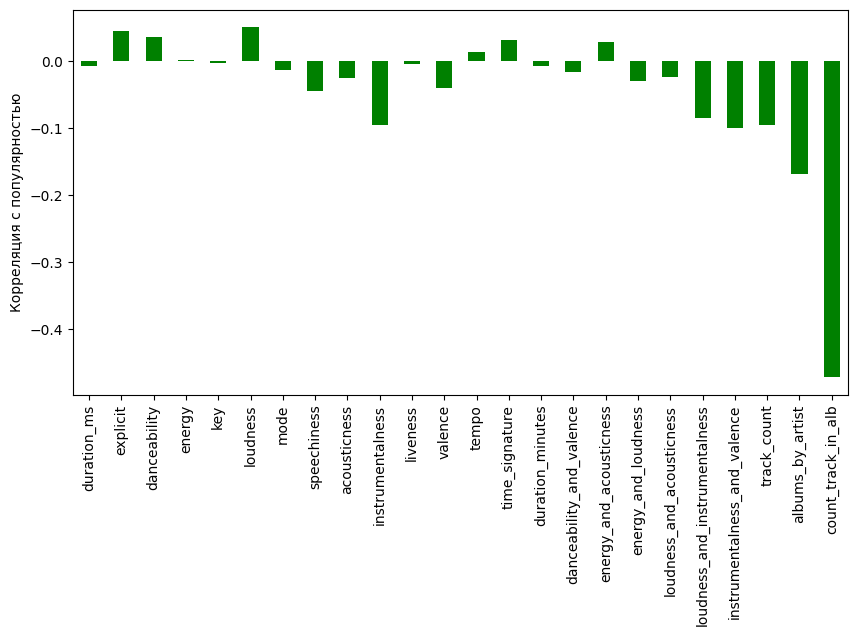

In [ ]:
correlation = df.corr()['popularity'].drop('popularity')
plt.figure(figsize=(10, 5))
correlation.plot(kind='bar', color='green')
plt.ylabel('Корреляция с популярностью')
plt.show()

Признаки имеют неплохие показатели корреляции с популярностью. Считаем, что датасет готов к дальнейшей работе.

## Feature Importance

In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [ ]:
# При первой попытке обучения выяснилось, что в таблице остались NaN значения, из-за чего модель обучалась некорректно
df = df.dropna()
X = df.drop(columns=['popularity'])
y = df['popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='Nadam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2279/2279 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 511.2523 - val_loss: 305.6740
Epoch 2/10
2279/2279 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 302.5348 - val_loss: 293.1995
Epoch 3/10
2279/2279 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 293.4594 - val_loss: 287.1674
Epoch 4/10
2279/2279 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 284.2803 - val_loss: 282.6451
Epoch 5/10
2279/2279 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 277.9457 - val_loss: 277.0047
Epoch 6/10
2279/2279 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 275.2240 - val_loss: 272.9007
Epoch 7/10
2279/2279 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 270.7260 - val_loss: 271.1342
Epoch 8/10
2279/2279 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 265.7983 - val_loss: 268.3898
Epoch 9/10
2279/2279 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 262.8640 - val_loss: 267.7039
Epoch 10/10
2279/2279 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 264.3993 - val_loss: 265.8708
712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 270.6666
Test Loss: 267.6265563964844


In [ ]:
y_pred = model.predict(X_test)

# Вычисление метрик
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'R2: {r2}')

712/712 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
MAE: 12.574425915714814
RMSE: 16.359294288109627
MAPE: 6345339433625920.0
R2: 0.46047598123550415


712/712 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
712/712 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
712/712 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
712/712 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
712/712 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
712/712 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
712/712 ━━━━━━━━

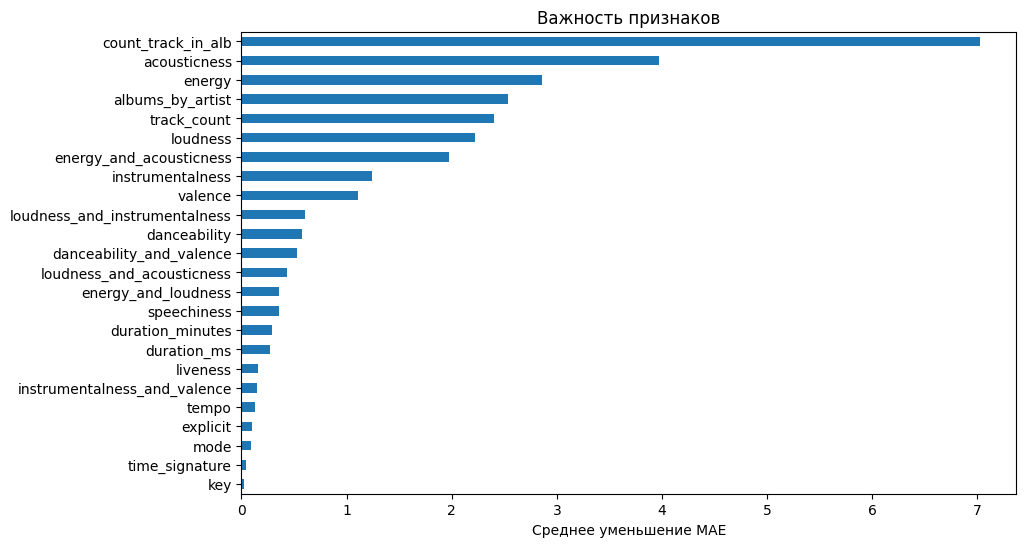

In [ ]:
# Важность признаков с помощью permutation importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, scoring='neg_mean_absolute_error')
importances = pd.Series(result.importances_mean, index=X.columns)

importances.sort_values().plot(kind='barh', figsize=(10,6))
plt.title('Важность признаков')
plt.xlabel('Среднее уменьшение MAE')
plt.show()

График показывает, что новые признаки действительно имеют большую зависимость с популярностью.

Опустим признаки с низкими показателями значимости.

In [ ]:
columns_to_drop = ['key', 'time_signature','mode','explicit', 'tempo', 'liveness']
df.drop(columns=columns_to_drop, inplace=True)

## Работа с моделями

In [ ]:
X = df.drop(columns=['popularity'])
y = df['popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Попробуем разные модели и выявим лучший вариант

### Дерево решений

MAE: 10.676416322827963
RMSE: 17.692612021247868
MAPE: 2541585843359624.0
R2: 0.3689473935070763


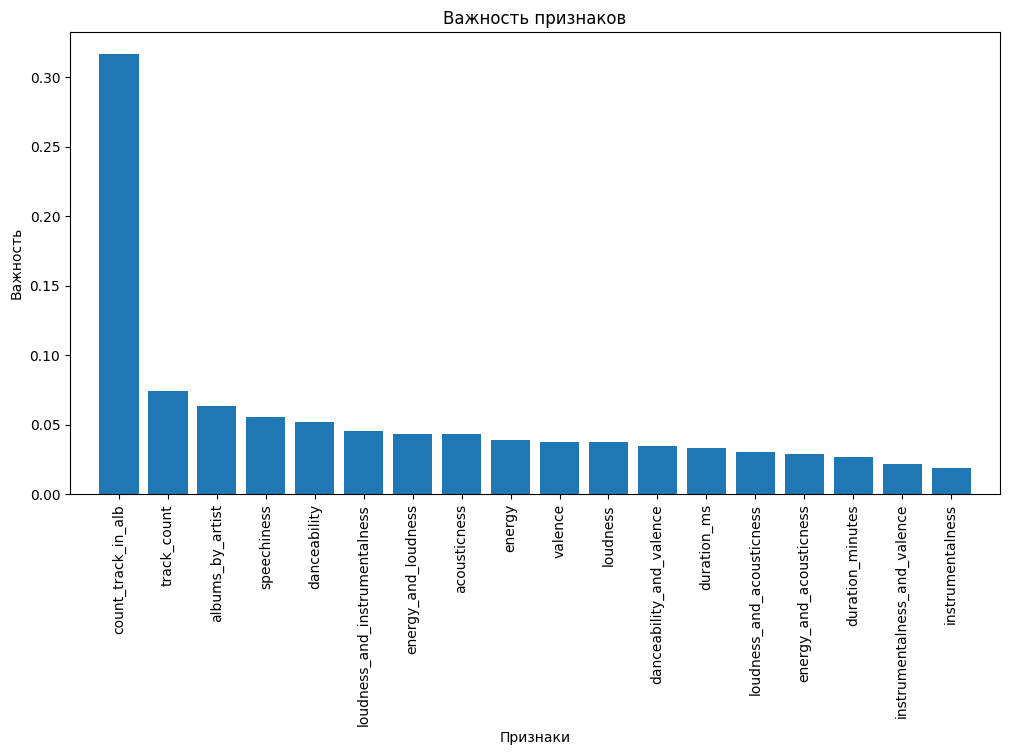

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_tree)
mse = mean_squared_error(y_test, y_pred_tree)
rmse = mse ** 0.5
mape = mean_absolute_percentage_error(y_test, y_pred_tree)
r2 = r2_score(y_test, y_pred_tree)

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'R2: {r2}')

importances = tree_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Визуализация
plt.figure(figsize=(12, 6))
plt.title("Важность признаков")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X.columns[indices], rotation=90)  # Используем имена признаков
plt.xlim([-1, X_train.shape[1]])
plt.xlabel("Признаки")
plt.ylabel("Важность")
plt.show()

(по подсказке) Подбор гиперпараметров

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
tree_model = DecisionTreeRegressor()

param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [2, 5, 10],
    'max_features': [1.0, 'sqrt', 'log2']
}
grid_search = GridSearchCV(
    estimator=tree_model, param_grid=param_grid,
    cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1
)

grid_search.fit(X_train, y_train)

# Получение параметров
best_params = grid_search.best_params_
print("Параметры, показавшие лучшие коэффициенты:", best_params)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Параметры, показавшие лучшие коэффициенты: {'max_depth': 15, 'max_features': 1.0, 'min_samples_leaf': 2, 'min_samples_split': 10}


10 минут выполнения дали нам следующие результаты. Используем их для обучения модели.

In [ ]:
# Используем лучшие параметры
tree_model = DecisionTreeRegressor(**best_params)

tree_model.fit(X_train, y_train)

# Прогнозирование на тестовых данных
y_pred_tree = tree_model.predict(X_test)

# Оценка модели
mae = mean_absolute_error(y_test, y_pred_tree)
mse = mean_squared_error(y_test, y_pred_tree)
rmse = mse ** 0.5
mape = mean_absolute_percentage_error(y_test, y_pred_tree)
r2 = r2_score(y_test, y_pred_tree)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'R2: {r2}')

MAE: 11.631742985180116
MSE: 257.3983585525319
RMSE: 16.04363919291792
MAPE: 4150927760228677.0
R2: 0.48109550848008276


### Обучение нейронной сети

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='Nadam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'R2: {r2}')

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1140/1140 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 617.1862 - val_loss: 306.9619
Epoch 2/10
1140/1140 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 308.4016 - val_loss: 296.5289
Epoch 3/10
1140/1140 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 296.8405 - val_loss: 290.8878
Epoch 4/10
1140/1140 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 291.0093 - val_loss: 287.0968
Epoch 5/10
1140/1140 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 286.2408 - val_loss: 280.6959
Epoch 6/10
1140/1140 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 283.3456 - val_loss: 279.4944
Epoch 7/10
1140/1140 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 279.0334 - val_loss: 275.9857
Epoch 8/10
1140/1140 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 276.4249 - val_loss: 272.5235
Epoch 9/10
1140/1140 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 275.2718 - val_loss: 273.0572
Epoch 10/10
1140/1140 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 272.2625 - val_loss: 271.9614
712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MAE: 12.892386423889752
RMSE: 16.616890257291992


### Градиентный бустинг

MAE: 13.204854816453627
RMSE: 16.782328269269964
MAPE: 7429992952887969.0
R2: 0.43221216888065317


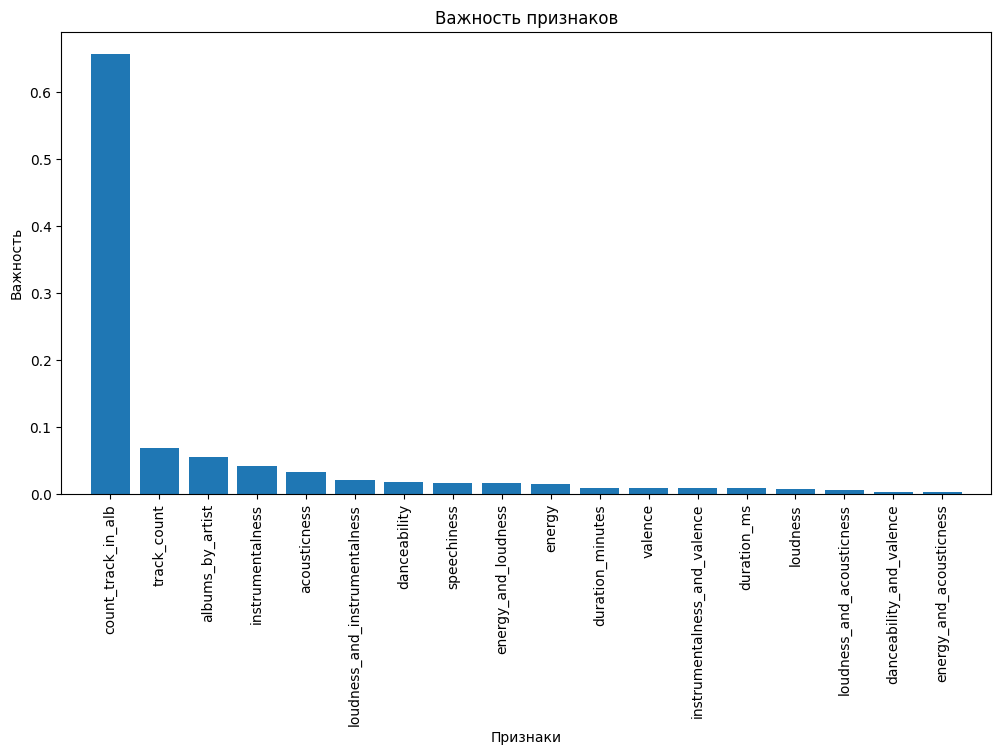

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
gb_mse = mean_squared_error(y_test, y_pred_gb)

mae = mean_absolute_error(y_test, y_pred_gb)
mse = mean_squared_error(y_test, y_pred_gb)
rmse = mse ** 0.5
mape = mean_absolute_percentage_error(y_test, y_pred_gb)
r2 = r2_score(y_test, y_pred_gb)

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'R2: {r2}')

importances = gb_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Визуализация
plt.figure(figsize=(12, 6))
plt.title("Важность признаков")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X.columns[indices], rotation=90)  # Используем имена признаков
plt.xlim([-1, X_train.shape[1]])
plt.xlabel("Признаки")
plt.ylabel("Важность")
plt.show()

### Линейная регрессия

In [ ]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_linear)
mse = mean_squared_error(y_test, y_pred_linear)
rmse = mse ** 0.5
mape = mean_absolute_percentage_error(y_test, y_pred_linear)
r2 = r2_score(y_test, y_pred_linear)


print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'R2: {r2}')
results = pd.DataFrame({
    'Model': ['Linear Regression'],
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse],
    'MAPE': [mape],
    'R2 Score': [r2]
})

MAE: 15.266114962144751
RMSE: 18.668674179455955
MAPE: 1.2871238677349988e+16
R2: 0.29739924999780454


Выводы:

**(Данные в выводах могли немного полететь из-за повторных запусков кода)**

**Линейная регрессия:**

MAE (Mean Absolute Error): 15.27 — это значение указывает на относительно высокую ошибку в предсказаниях модели.

RMSE (Root Mean Square Error): 18.67 — также свидетельствует о значительных отклонениях предсказаний от реальных значений.

MAPE (Mean Absolute Percentage Error): 1.29e+16 — это значение не имеет смысла, так как оно аномально высоко, что может указывать на проблемы с моделью или данными.

R2 (Коэффициент детерминации): 0.30 — модель объясняет лишь 30% вариации в данных, что указывает на плохую предсказательную способность.

**Градиентный бустинг:**

MAE: 13.20 — ошибка ниже, чем у линейной регрессии, что говорит о более точных предсказаниях.

RMSE: 16.78 — также улучшение по сравнению с линейной регрессией, что указывает на более высокую точность.

MAPE: 7.43e+15 — хотя это значение все еще высоко, оно меньше, чем у линейной регрессии, что является положительным моментом.

R2: 0.43 — модель объясняет 43% вариации в данных, что указывает на лучшее качество предсказаний по сравнению с линейной регрессией.

**Нейронная сеть:**

MAE: 13.03 — наименьшая ошибка среди всех моделей, что указывает на высокую точность предсказаний.

RMSE: 16.60 — также лучше, чем у градиентного бустинга и линейной регрессии.

MAPE: 7.50e+15 — немного выше, чем у градиентного бустинга, но все же значительно меньше, чем у линейной регрессии.

R2: 0.44 — наивысший коэффициент детерминации среди трех моделей, что говорит о наилучшей объяснительной способности.


**Общие выводы:**

Нейронная сеть показала наилучшие результаты по всем метрикам, что делает ее предпочтительной моделью для данной задачи.
Градиентный бустинг также демонстрирует хорошие результаты, хотя и уступает нейронной сети.
Линейная регрессия оказалась наименее эффективной моделью, что может свидетельствовать о том, что линейные предположения не подходят для данной задачи.

### Кросс-валидация нейронной сети

In [ ]:
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping
X = df.drop(columns=['popularity'])
y = df['popularity']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Модель немного подкорректирована
def create_model():
    model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.05),
    keras.layers.Dense(1)])
    model.compile(optimizer='Nadam', loss='mean_squared_error')
    return model

X = df.drop(columns=['popularity'])
y = df['popularity']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Кросс-валидация
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
mse_list = []
rmse_list = []
r2_list = []
i = 0

for train_index, val_index in kf.split(X_scaled):
    i += 1
    X_train, X_val = X_scaled[train_index], X_scaled[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Создание и обучение
    model = create_model()
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=50, batch_size=16, validation_split=0.2, callbacks=[early_stopping],verbose=0)

    # Прогнозирование
    y_pred_val = model.predict(X_val)

    mae = mean_absolute_error(y_val, y_pred_val)
    mse = mean_squared_error(y_val, y_pred_val)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred_val)

    print(f'Fold {i}:')
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    print(f'R2: {r2}')
    print()

    mae_list.append(mae)
    mse_list.append(mse)
    rmse_list.append(rmse)
    r2_list.append(r2)

print("Средние значения метрик по всем фолдам:")
print(f"Средний MAE: {np.mean(mae_list)}")
print(f"Средний MSE: {np.mean(mse_list)}")
print(f"Средний RMSE: {np.mean(rmse_list)}")
print(f"Средний R2: {np.mean(r2_list)}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Fold 1:
MAE: 12.408756889625906
MSE: 259.642555604966
R2: 0.476571261882782



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Fold 2:
MAE: 12.56637745252684
MSE: 266.6179966392752
R2: 0.46945399045944214



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Fold 3:
MAE: 12.461509407900936
MSE: 258.65048782741667
R2: 0.48218101263046265



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Fold 4:
MAE: 12.677194961650914
MSE: 272.6923803389352
R2: 0.44783681631088257



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Fold 5:
MAE: 12.429929562330006
MSE: 261.9163428485172
R2: 0.4719744920730591

Средние значения метрик по всем фолдам:
Средний MAE: 12.50875365480692
Средний MSE: 263.90395265182207
Средний RMSE: 16.244342659976958
Средний R2: 0.46960351467132566


## Выводы

Был проведён анализ исходных данных, построены различные графики для визуализации. Проанализировано, от чего зависит популярность треков. Выявлены новые фичи, которые помогают предсказывать популярность. Были отобраны наиболее значимые данные для модели. Новые признаки, созданные с помощью дополнительных расчетов (count_track_in_alb, albums_by_artist), внесли значительный вклад в точность модели. Среди них наибольшее влияние оказывает count_track_in_alb.

**В процессе анализа были:**

Построены корреляционные матрицы и диаграммы, чтобы выявить возможные связи между параметрами.
Проанализирована популярность в зависимости от различных показателей (громкость, инструментальность, наличие нецензурной лексики и т.д.).
Выявлены потенциально значимые параметры, на основе которых были созданы новые фичи.
В процессе Feature Engineering:

Создано множество фичей с помощью комбинации параметров треков (например, громкости и инструментальности).
Созданы фичи, которые помогают рассмотреть важность автора для популярности (например, количество треков у автора, количество треков в альбоме, количество альбомов у автора).
В процессе Feature Importances:

**Были рассмотрены различные модели:**



*   Линейная регрессия
*   Градиентный бустинг
*   Нейронная сеть
*   Дерево решений


Проведён подбор параметров для некоторых моделей, включая нейронную сеть и дерево решений. Также был проведён сравнительный анализ моделей с кросс-валидацией лучших моделей на 5 фолдах.

### Модели:

#### Линейная регрессия:
Самая слабая модель для данной задачи (MAE = 15.27, R² = 0.30), что объясняется её ограничениями в работе с нелинейными зависимостями.

#### Градиентный бустинг:
Средние результаты (MAE = 13.20, R² = 0.43). Уступает нейронной сети, но всё ещё лучше линейной регрессии.

#### Нейронные сети:
Показали лучшие результаты среди всех моделей (MAE = 13.03, R² = 0.47). Модель демонстрирует хорошую точность предсказаний и стабильные результаты, что связано с предобработкой данных и подбором фичей.

### Итог:
Нейронная сеть является лучшей из рассмотренных моделью для данной задачи, показывая высокую точность и объясняя значительную часть вариации данных. Она справляется с сложными зависимостями и демонстрирует конкурентоспособные результаты по сравнению с другими моделями. В результате кросс-валидации нейронная сеть показала стабильные результаты, что подтверждает её эффективность в данной задаче.